In [353]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

# Otro intento

* `resize` con grid más grande en vez de `pyrDown` y `pyrUp`
* Todo modularizado y listo
* NMS sobre todas las escalas juntas
* supervision para NMS

In [354]:
PATH_MAT = Path("./material")
PATH_IMGS = PATH_MAT / "images"
PATH_TEMPLATE = PATH_MAT / "template" / "pattern.png"

In [355]:
# util para generar color
def str_to_opencv(color: str) -> tuple[int,int,int]:
    rgb = to_rgb(color)
    return tuple(int(255*x) for x in rgb[::-1])

# mostramos para rojo y negro
str_to_opencv('red'), str_to_opencv('black')

((0, 0, 255), (0, 0, 0))

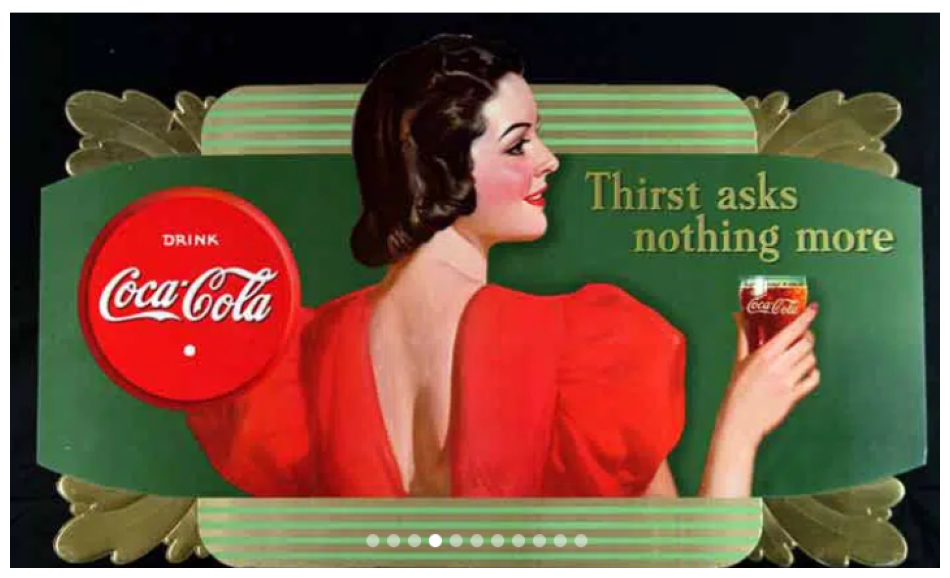

In [356]:
# levantamos una imagen ejemplo
fname = 'coca_retro_2.png'

img_rgb = cv.imread(PATH_IMGS / fname)
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

sv.plot_image(img_rgb)

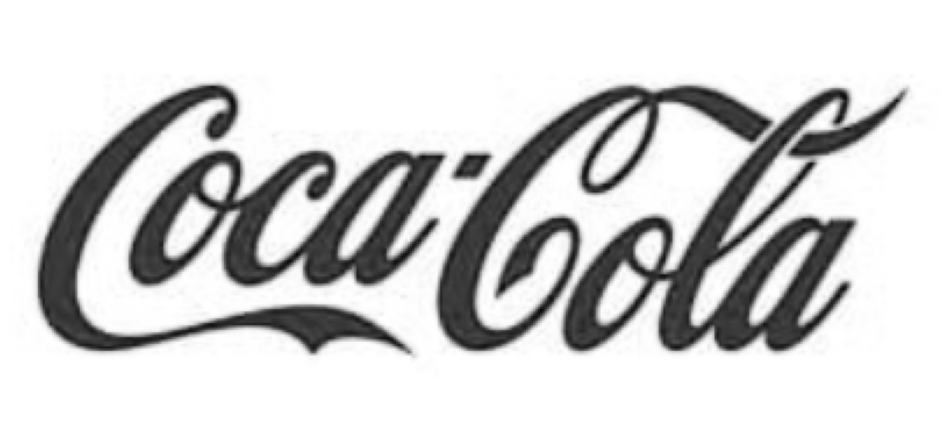

In [357]:
# mostramos el template
template = cv.imread(PATH_TEMPLATE, cv.IMREAD_GRAYSCALE)

sv.plot_image(template)

In [358]:
to_rgb('red')

(1.0, 0.0, 0.0)

In [359]:
# utils
def plot_boxes_xyxy(
        boxes: list[tuple[int,int,int,int]] | np.ndarray,
        scores: list[float] | np.ndarray | None,
        base_img: np.ndarray,
        color: tuple[int,int,int] | str = (0,0,255),
        width: int = 2,
        fontScale: float = 0.35,
        fontWidth: int = 1
):
    img_copy = base_img.copy()

    if isinstance(boxes, np.ndarray):
        boxes = boxes.tolist()

    if scores is not None and isinstance(scores,np.ndarray):
        scores = scores.tolist()
    elif scores is None:
        scores = [None] * len(boxes)

    if isinstance(color, str):
        color = str_to_opencv(color)

    for (x1,y1,x2,y2),score in zip(boxes, scores):
        cv.rectangle(img_copy, (x1,y1), (x2,y2), color, width)
        if score is not None:
            label = str(round(score, 3))
            (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, fontScale, fontWidth)

            text_end = (x1 + label_width, y1 - label_height)
            cv.rectangle(img_copy, (x1,y1), text_end, (0,0,0),-1)
            cv.putText(img_copy, label, (x1,y1), cv.FONT_HERSHEY_SIMPLEX, fontScale, (255,255,255), fontWidth)
        
    sv.plot_image(img_copy)



def plot_boxes(
        xy: tuple[np.ndarray,np.ndarray],
        template: np.ndarray, 
        base_img: np.ndarray,
        scores: np.ndarray | None = None
    ):
    img_copy = base_img.copy()
    h,w = template.shape

    x1, y1 = xy
    xyxy = np.column_stack((x1,y1,x1+w,y1+h))

    plot_boxes_xyxy(xyxy, scores, base_img)

In [360]:
aux = cv.resize(img_gs, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

aux

array([[255, 255, 255, ..., 255, 255, 255],
       [  7,   7,   7, ...,  16,  16,  16],
       [  7,   7,   7, ...,  16,  16,  16],
       ...,
       [ 13,  13,  14, ...,  13,  13,  11],
       [ 14,  14,  14, ...,  14,  12,  10],
       [ 14,  14,  14, ...,  14,   9,   6]], dtype=uint8)

In [361]:
cv.matchTemplate(img_gs, template, cv.TM_CCOEFF_NORMED).min()

-0.22617012

In [362]:
MIN_BEST_METHODS = {cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED}


def multi_instance_template_matching(
    image: np.ndarray,
    template: np.ndarray,
    method: int = cv.TM_CCOEFF_NORMED,
    threshold: float = 0.8,
    max_overlap: float = 0.4,
    scale_range: tuple[float, float] = (0.2, 1.5),
    scale_step: float = 0.1,
    canny_threshold1: int = 100,
    canny_threshold2: int = 200,
    image_scale: float = 1,
    debug: bool = False
) -> tuple[list[tuple[int, int, int, int]], list[float]]:

    # Canny
    if (abs(image_scale-1) > 0.0001):
        image = cv.resize(image, None, fx=image_scale, fy=image_scale, interpolation=cv.INTER_LINEAR)
    image_edges = cv.Canny(image, canny_threshold1, canny_threshold2)
    template_edges = cv.Canny(template, canny_threshold1, canny_threshold2)

    boxes = []
    scores = []
    min_scale, max_scale = scale_range

    for scale_x in np.arange(min_scale, max_scale + scale_step, scale_step):
        for scale_y in np.arange(min_scale, max_scale + scale_step, scale_step):


            # resize template
            scaled_template = cv.resize(
                template_edges, None, 
                fx=scale_x, fy=scale_y, 
                interpolation=cv.INTER_LINEAR
            ) # type: ignore

            h, w = scaled_template.shape

            if image_edges.shape[0] < h or image_edges.shape[1] < w:
                if debug:
                    print(f"Scale {scale_x}, {scale_y} out of base image bounds")
                break

            result = cv.matchTemplate(image_edges, scaled_template, method)

            if method in MIN_BEST_METHODS:
                match_indices = np.where(result <= threshold)
                confidences = 1.0 - result[match_indices]
            else:
                match_indices = np.where(result >= threshold)
                confidences = result[match_indices]

            for (y, x), conf in zip(zip(*match_indices), confidences):
                # reescalar al tamaño original (image_scale es el factor usado en cv.resize)
                x1 = int(round(x / image_scale))
                y1 = int(round(y / image_scale))
                x2 = int(round((x+w) / image_scale))
                y2 = int(round((y+h) / image_scale))

                boxes.append([x1, y1, x2, y2])
                scores.append(conf.item())

            if debug:
                print("".join([
                    f"Scale {scale_x:>.3f}, {scale_y:>.3f}:",
                    f"[{result.min().round(3).item():<.4f}, {result.max().round(3).item():>.4f}]",
                    f" pre-NMS={len(confidences)}"]))

    if boxes:
        detections = sv.Detections( # type: ignore
            xyxy=np.array(boxes),
            confidence=np.array(scores)
        )
        detections = detections.with_nms(threshold=max_overlap, class_agnostic=True)
        return detections.xyxy.tolist(), detections.confidence.tolist() # type: ignore

    return [], []


In [363]:
dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.17,
    scale_range = (0.2, 1.8),
    scale_step= 0.1,
    debug=True
)

len(dets)

Scale 0.200, 0.200:[-0.0870, 0.1610] pre-NMS=0
Scale 0.200, 0.300:[-0.0780, 0.1280] pre-NMS=0
Scale 0.200, 0.400:[-0.0770, 0.1290] pre-NMS=0
Scale 0.200, 0.500:[-0.0800, 0.1000] pre-NMS=0
Scale 0.200, 0.600:[-0.0730, 0.1050] pre-NMS=0
Scale 0.200, 0.700:[-0.0710, 0.1000] pre-NMS=0
Scale 0.200, 0.800:[-0.0690, 0.0970] pre-NMS=0
Scale 0.200, 0.900:[-0.0730, 0.0940] pre-NMS=0
Scale 0.200, 1.000:[-0.0660, 0.0840] pre-NMS=0
Scale 0.200, 1.100:[-0.0720, 0.0820] pre-NMS=0
Scale 0.200, 1.200:[-0.0700, 0.0820] pre-NMS=0
Scale 0.200, 1.300:[-0.0650, 0.0790] pre-NMS=0
Scale 0.200, 1.400:[-0.0560, 0.0710] pre-NMS=0
Scale 0.200, 1.500:[-0.0580, 0.0700] pre-NMS=0
Scale 0.200, 1.600:[-0.0550, 0.0670] pre-NMS=0
Scale 0.200, 1.700:[-0.0510, 0.0730] pre-NMS=0
Scale 0.200, 1.800:[-0.0520, 0.0780] pre-NMS=0
Scale 0.300, 0.200:[-0.0910, 0.1410] pre-NMS=0
Scale 0.300, 0.300:[-0.0830, 0.1170] pre-NMS=0
Scale 0.300, 0.400:[-0.0800, 0.1370] pre-NMS=0
Scale 0.300, 0.500:[-0.0830, 0.1140] pre-NMS=0
Scale 0.300, 

1

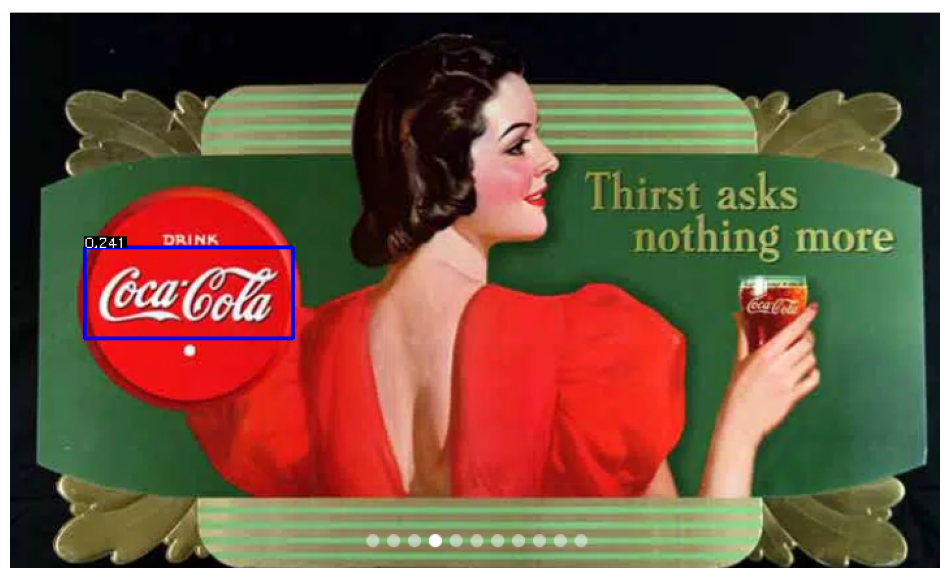

In [364]:
plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

Otras imágenes

Scale 0.200, 0.200:[-0.1050, 0.1210] pre-NMS=0
Scale 0.200, 0.300:[-0.0870, 0.1090] pre-NMS=0
Scale 0.200, 0.400:[-0.0800, 0.1010] pre-NMS=0
Scale 0.200, 0.500:[-0.0760, 0.0900] pre-NMS=0
Scale 0.200, 0.600:[-0.0660, 0.0800] pre-NMS=0
Scale 0.200, 0.700:[-0.0730, 0.0800] pre-NMS=0
Scale 0.200, 0.800:[-0.0650, 0.0890] pre-NMS=0
Scale 0.200, 0.900:[-0.0670, 0.0910] pre-NMS=0
Scale 0.200, 1.000:[-0.0600, 0.0800] pre-NMS=0
Scale 0.200, 1.100:[-0.0640, 0.0950] pre-NMS=0
Scale 0.200, 1.200:[-0.0670, 0.0890] pre-NMS=0
Scale 0.200, 1.300:[-0.0710, 0.0970] pre-NMS=0
Scale 0.200, 1.400:[-0.0650, 0.0920] pre-NMS=0
Scale 0.200, 1.500:[-0.0650, 0.0890] pre-NMS=0
Scale 0.200, 1.600:[-0.0650, 0.0800] pre-NMS=0
Scale 0.200, 1.700:[-0.0570, 0.0810] pre-NMS=0
Scale 0.200, 1.800:[-0.0470, 0.0760] pre-NMS=0
Scale 0.300, 0.200:[-0.1000, 0.1100] pre-NMS=0
Scale 0.300, 0.300:[-0.0980, 0.1130] pre-NMS=0
Scale 0.300, 0.400:[-0.0770, 0.1440] pre-NMS=0
Scale 0.300, 0.500:[-0.0740, 0.1210] pre-NMS=0
Scale 0.300, 

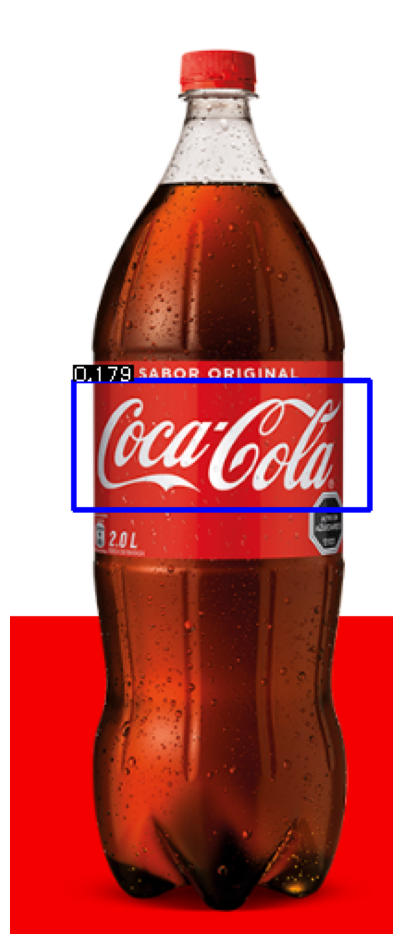

In [365]:
img_rgb = cv.imread(PATH_IMGS / 'coca_logo_1.png')
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.17,
    scale_range = (0.2, 1.8),
    scale_step= 0.1,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

Scale 0.200, 0.200:[-0.0940, 0.1310] pre-NMS=0
Scale 0.200, 0.300:[-0.0870, 0.1120] pre-NMS=0
Scale 0.200, 0.400:[-0.0850, 0.1110] pre-NMS=0
Scale 0.200, 0.500:[-0.0770, 0.0980] pre-NMS=0
Scale 0.200, 0.600:[-0.0750, 0.0800] pre-NMS=0
Scale 0.200, 0.700:[-0.0710, 0.0870] pre-NMS=0
Scale 0.200, 0.800:[-0.0670, 0.0890] pre-NMS=0
Scale 0.200, 0.900:[-0.0710, 0.0850] pre-NMS=0
Scale 0.200, 1.000:[-0.0640, 0.0690] pre-NMS=0
Scale 0.200, 1.100:[-0.0640, 0.0760] pre-NMS=0
Scale 0.200, 1.200:[-0.0590, 0.0730] pre-NMS=0
Scale 0.200, 1.300:[-0.0540, 0.0730] pre-NMS=0
Scale 0.200, 1.400:[-0.0570, 0.0820] pre-NMS=0
Scale 0.200, 1.500:[-0.0510, 0.0760] pre-NMS=0
Scale 0.200, 1.600:[-0.0380, 0.0620] pre-NMS=0
Scale 0.200, 1.700:[-0.0430, 0.0640] pre-NMS=0
Scale 0.200, 1.800:[-0.0370, 0.0620] pre-NMS=0
Scale 0.300, 0.200:[-0.0970, 0.1130] pre-NMS=0
Scale 0.300, 0.300:[-0.0880, 0.1140] pre-NMS=0
Scale 0.300, 0.400:[-0.0760, 0.0990] pre-NMS=0
Scale 0.300, 0.500:[-0.0750, 0.0900] pre-NMS=0
Scale 0.300, 

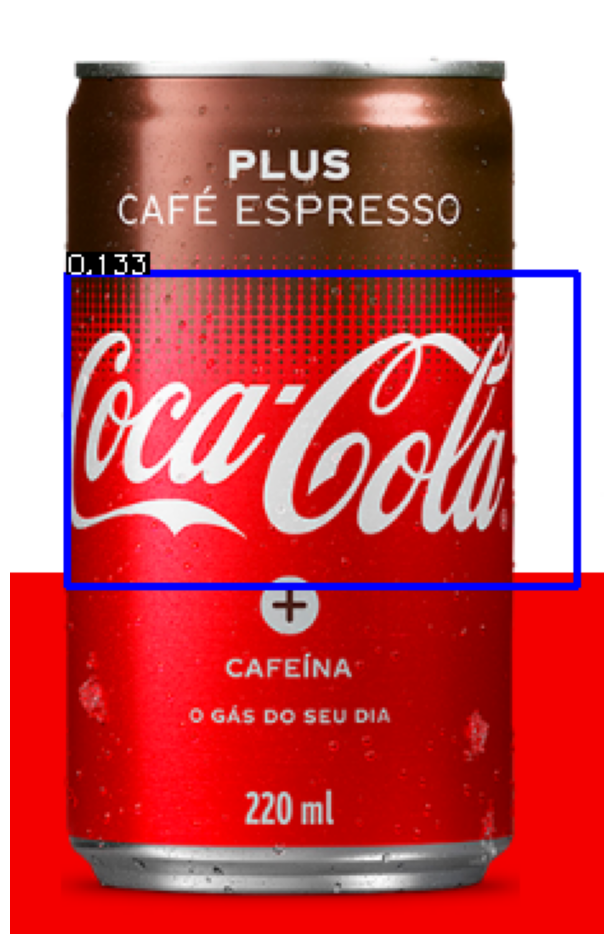

In [366]:
img_rgb = cv.imread(PATH_IMGS / 'coca_logo_2.png')
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.133,
    scale_range = (0.2, 1.8),
    scale_step= 0.1,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

**En esta imagen no funciona**

Scale 0.200, 0.200:[-0.1060, 0.1550] pre-NMS=0
Scale 0.200, 0.300:[-0.1090, 0.1130] pre-NMS=0
Scale 0.200, 0.400:[-0.0980, 0.1140] pre-NMS=0
Scale 0.200, 0.500:[-0.0930, 0.1130] pre-NMS=0
Scale 0.200, 0.600:[-0.0770, 0.1050] pre-NMS=0
Scale 0.200, 0.700:[-0.0700, 0.1130] pre-NMS=0
Scale 0.200, 0.800:[-0.0720, 0.1050] pre-NMS=0
Scale 0.200, 0.900:[-0.0690, 0.1000] pre-NMS=0
Scale 0.200, 1.000:[-0.0670, 0.0990] pre-NMS=0
Scale 0.200, 1.100:[-0.0660, 0.0920] pre-NMS=0
Scale 0.200, 1.200:[-0.0610, 0.0890] pre-NMS=0
Scale 0.200, 1.300:[-0.0620, 0.0910] pre-NMS=0
Scale 0.200, 1.400:[-0.0640, 0.0850] pre-NMS=0
Scale 0.200, 1.500:[-0.0650, 0.0840] pre-NMS=0
Scale 0.200, 1.600:[-0.0630, 0.0780] pre-NMS=0
Scale 0.200, 1.700:[-0.0610, 0.0730] pre-NMS=0
Scale 0.200, 1.800:[-0.0590, 0.0730] pre-NMS=0
Scale 0.300, 0.200:[-0.1090, 0.1440] pre-NMS=0
Scale 0.300, 0.300:[-0.1230, 0.1160] pre-NMS=0
Scale 0.300, 0.400:[-0.1070, 0.1100] pre-NMS=0
Scale 0.300, 0.500:[-0.0930, 0.1300] pre-NMS=0
Scale 0.300, 

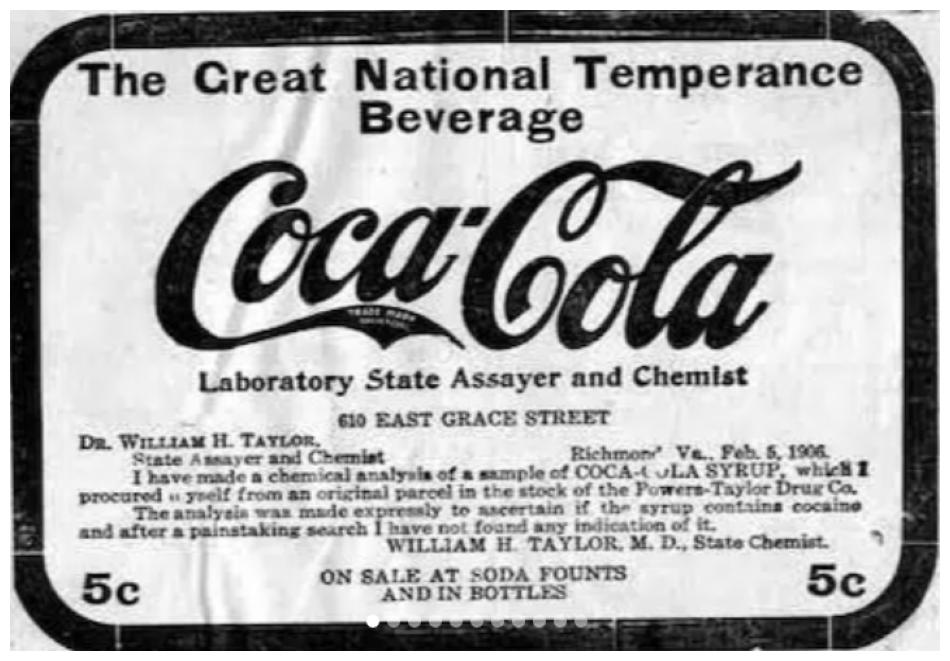

In [367]:
img_rgb = cv.imread(PATH_IMGS / 'coca_retro_1.png')
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.17,
    scale_range = (0.2, 1.8),
    scale_step= 0.1,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

**En este tampoco funciona!**

In [368]:
template.shape

(175, 400)

Scale 0.200, 0.200:[-0.0670, 0.1040] pre-NMS=0
Scale 0.200, 0.300:[-0.0550, 0.0780] pre-NMS=0
Scale 0.200, 0.400:[-0.0450, 0.0680] pre-NMS=0
Scale 0.200, 0.500:[-0.0340, 0.0620] pre-NMS=0
Scale 0.200, 0.600:[-0.0240, 0.0690] pre-NMS=0
Scale 0.200, 0.700:[-0.0190, 0.0660] pre-NMS=0
Scale 0.2, 0.8000000000000003 out of base image bounds
Scale 0.300, 0.200:[-0.0440, 0.0950] pre-NMS=0
Scale 0.300, 0.300:[-0.0440, 0.1140] pre-NMS=1
Scale 0.300, 0.400:[-0.0370, 0.0850] pre-NMS=0
Scale 0.300, 0.500:[-0.0170, 0.0830] pre-NMS=0
Scale 0.300, 0.600:[0.0010, 0.0620] pre-NMS=0
Scale 0.300, 0.700:[0.0010, 0.0590] pre-NMS=0
Scale 0.30000000000000004, 0.8000000000000003 out of base image bounds
Scale 0.4000000000000001, 0.2 out of base image bounds
Scale 0.5000000000000001, 0.2 out of base image bounds
Scale 0.6000000000000001, 0.2 out of base image bounds
Scale 0.7000000000000002, 0.2 out of base image bounds
Scale 0.8000000000000003, 0.2 out of base image bounds
Scale 0.9000000000000001, 0.2 out of 

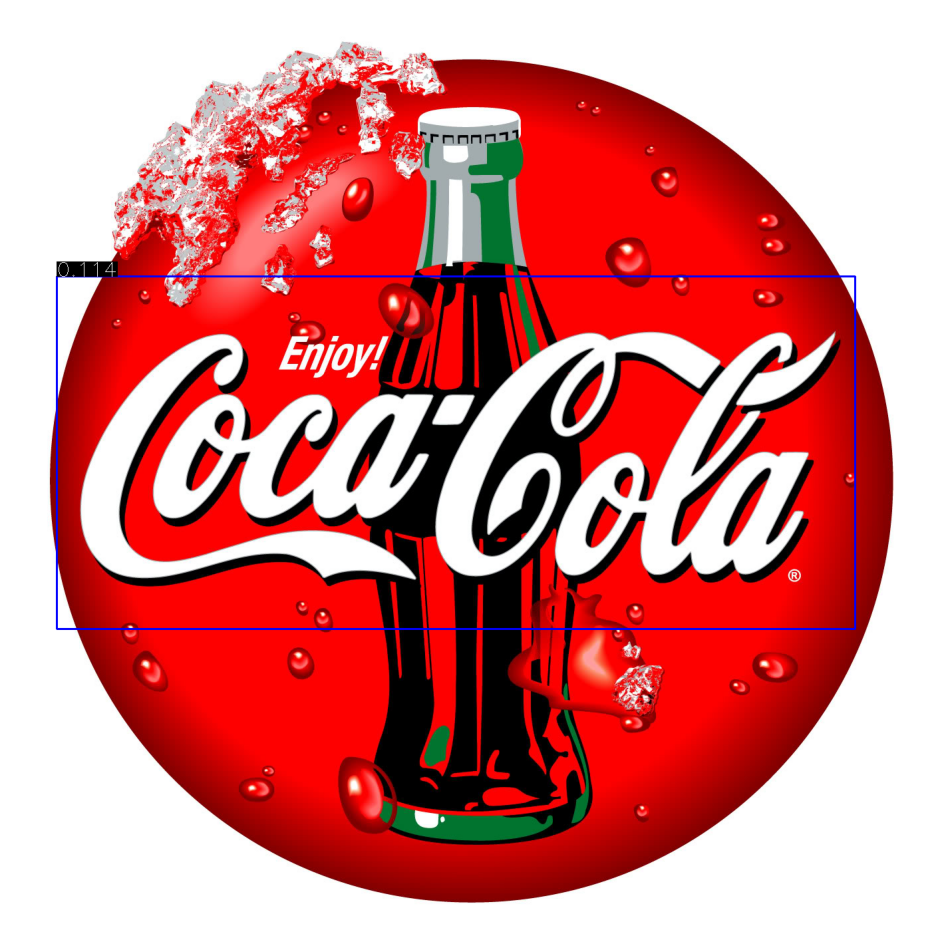

In [382]:
img_rgb = cv.imread(PATH_IMGS / 'COCA-COLA-LOGO.jpg')
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.11,
    scale_range = (0.2, 3),
    scale_step= 0.1,
    image_scale=0.1,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=1, color='blue')

Scale 0.200, 0.200:[-0.0910, 0.1190] pre-NMS=0
Scale 0.200, 0.300:[-0.0700, 0.1070] pre-NMS=0
Scale 0.200, 0.400:[-0.0620, 0.0960] pre-NMS=0
Scale 0.200, 0.500:[-0.0490, 0.0850] pre-NMS=0
Scale 0.200, 0.600:[-0.0420, 0.0770] pre-NMS=0
Scale 0.200, 0.700:[-0.0400, 0.0950] pre-NMS=0
Scale 0.200, 0.800:[-0.0380, 0.0840] pre-NMS=0
Scale 0.200, 0.900:[-0.0370, 0.0840] pre-NMS=0
Scale 0.200, 1.000:[-0.0320, 0.0860] pre-NMS=0
Scale 0.200, 1.100:[-0.0350, 0.1050] pre-NMS=0
Scale 0.200, 1.200:[-0.0330, 0.1070] pre-NMS=0
Scale 0.2, 1.3000000000000003 out of base image bounds
Scale 0.300, 0.200:[-0.0780, 0.0920] pre-NMS=0
Scale 0.300, 0.300:[-0.0730, 0.0970] pre-NMS=0
Scale 0.300, 0.400:[-0.0690, 0.1370] pre-NMS=2
Scale 0.300, 0.500:[-0.0490, 0.0920] pre-NMS=0
Scale 0.300, 0.600:[-0.0440, 0.0850] pre-NMS=0
Scale 0.300, 0.700:[-0.0410, 0.1090] pre-NMS=0
Scale 0.300, 0.800:[-0.0390, 0.0970] pre-NMS=0
Scale 0.300, 0.900:[-0.0350, 0.0800] pre-NMS=0
Scale 0.300, 1.000:[-0.0270, 0.0800] pre-NMS=0
Scale

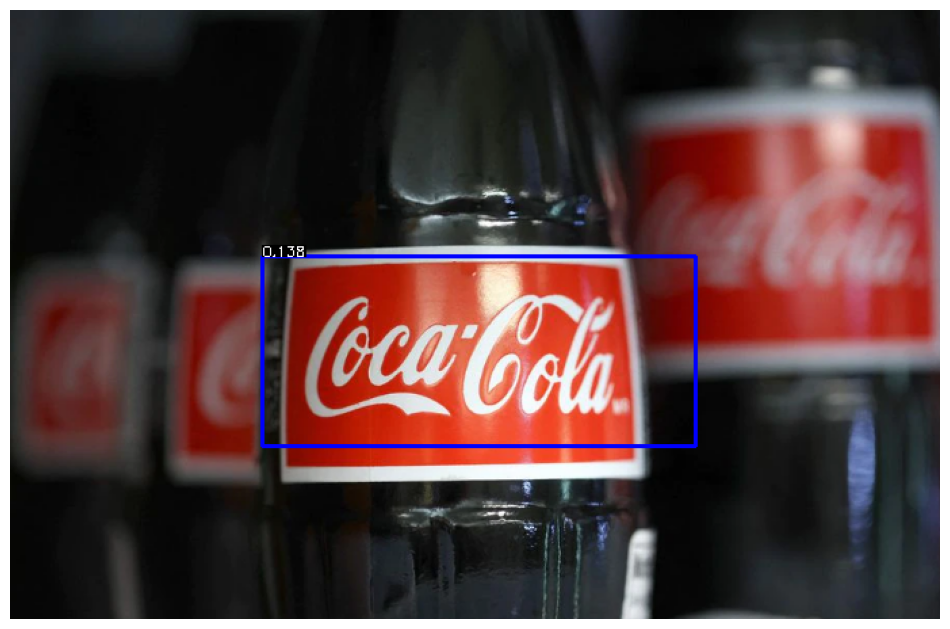

In [383]:
img_rgb = cv.imread(PATH_IMGS / 'logo_1.png')
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.13,
    scale_range = (0.2, 3),
    scale_step= 0.1,
    image_scale=0.5,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

Cambiando el threshold, lo detecta pero con algunos falsos positivos.

Detecciones: 116


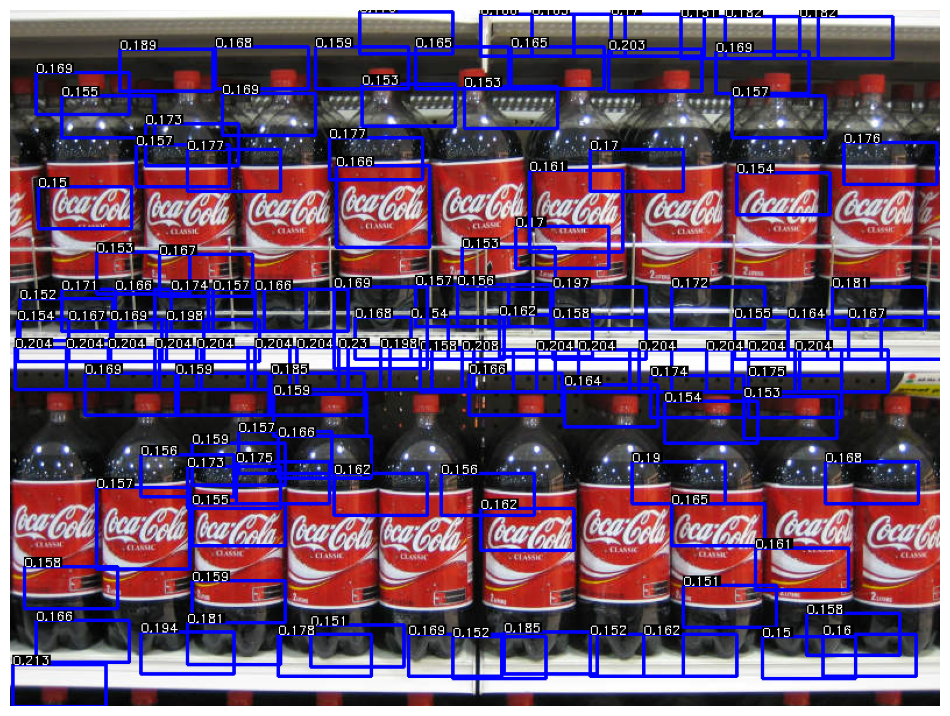

In [399]:
img_rgb = cv.imread(PATH_IMGS / 'coca_multi.png')
img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

dets, scores = multi_instance_template_matching(
    img_gs,
    template,
    threshold=0.15,
    scale_range = (0.1, 1),
    scale_step= 0.1,
    image_scale=0.5,
    debug=False
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

Scale 0.200, 0.200:[-0.0930, 0.1730] pre-NMS=221
Scale 0.200, 0.300:[-0.0790, 0.1400] pre-NMS=68
Scale 0.200, 0.400:[-0.0770, 0.1090] pre-NMS=5
Scale 0.200, 0.500:[-0.0680, 0.1040] pre-NMS=2
Scale 0.200, 0.600:[-0.0610, 0.0840] pre-NMS=0
Scale 0.200, 0.700:[-0.0610, 0.0890] pre-NMS=0
Scale 0.200, 0.800:[-0.0570, 0.0760] pre-NMS=0
Scale 0.200, 0.900:[-0.0620, 0.0840] pre-NMS=0
Scale 0.200, 1.000:[-0.0540, 0.0790] pre-NMS=0
Scale 0.200, 1.100:[-0.0580, 0.0850] pre-NMS=0
Scale 0.200, 1.200:[-0.0590, 0.0940] pre-NMS=0
Scale 0.200, 1.300:[-0.0620, 0.0840] pre-NMS=0
Scale 0.200, 1.400:[-0.0580, 0.0820] pre-NMS=0
Scale 0.200, 1.500:[-0.0560, 0.0730] pre-NMS=0
Scale 0.200, 1.600:[-0.0560, 0.0710] pre-NMS=0
Scale 0.200, 1.700:[-0.0600, 0.0730] pre-NMS=0
Scale 0.200, 1.800:[-0.0620, 0.0750] pre-NMS=0
Scale 0.200, 1.900:[-0.0580, 0.0740] pre-NMS=0
Scale 0.200, 2.000:[-0.0570, 0.0770] pre-NMS=0
Scale 0.200, 2.100:[-0.0490, 0.0690] pre-NMS=0
Scale 0.200, 2.200:[-0.0470, 0.0620] pre-NMS=0
Scale 0.20

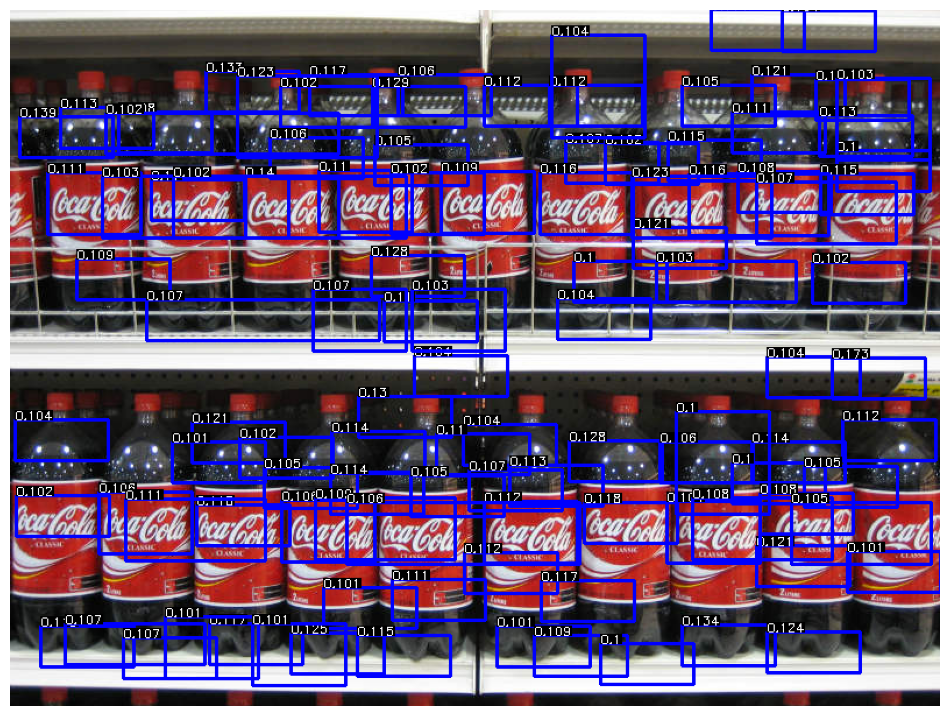

In [371]:
# a ver con gaussian blur previo...
dets, scores = multi_instance_template_matching(
    cv.GaussianBlur(img_gs, (5,5), sigmaX=3, sigmaY=3),
    template,
    threshold=0.1,
    scale_range = (0.2, 3),
    scale_step= 0.1,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

Scale 0.200, 0.200:[-0.0910, 0.1210] pre-NMS=72
Scale 0.200, 0.300:[-0.0840, 0.1330] pre-NMS=82
Scale 0.200, 0.400:[-0.0710, 0.1050] pre-NMS=4
Scale 0.200, 0.500:[-0.0680, 0.1080] pre-NMS=4
Scale 0.200, 0.600:[-0.0600, 0.0890] pre-NMS=0
Scale 0.200, 0.700:[-0.0540, 0.0930] pre-NMS=0
Scale 0.200, 0.800:[-0.0580, 0.0760] pre-NMS=0
Scale 0.200, 0.900:[-0.0600, 0.0750] pre-NMS=0
Scale 0.200, 1.000:[-0.0530, 0.0790] pre-NMS=0
Scale 0.200, 1.100:[-0.0580, 0.0850] pre-NMS=0
Scale 0.200, 1.200:[-0.0590, 0.0880] pre-NMS=0
Scale 0.200, 1.300:[-0.0640, 0.0840] pre-NMS=0
Scale 0.200, 1.400:[-0.0590, 0.0790] pre-NMS=0
Scale 0.200, 1.500:[-0.0580, 0.0760] pre-NMS=0
Scale 0.200, 1.600:[-0.0580, 0.0740] pre-NMS=0
Scale 0.200, 1.700:[-0.0580, 0.0770] pre-NMS=0
Scale 0.200, 1.800:[-0.0610, 0.0730] pre-NMS=0
Scale 0.200, 1.900:[-0.0580, 0.0710] pre-NMS=0
Scale 0.200, 2.000:[-0.0560, 0.0710] pre-NMS=0
Scale 0.200, 2.100:[-0.0500, 0.0680] pre-NMS=0
Scale 0.200, 2.200:[-0.0460, 0.0620] pre-NMS=0
Scale 0.200

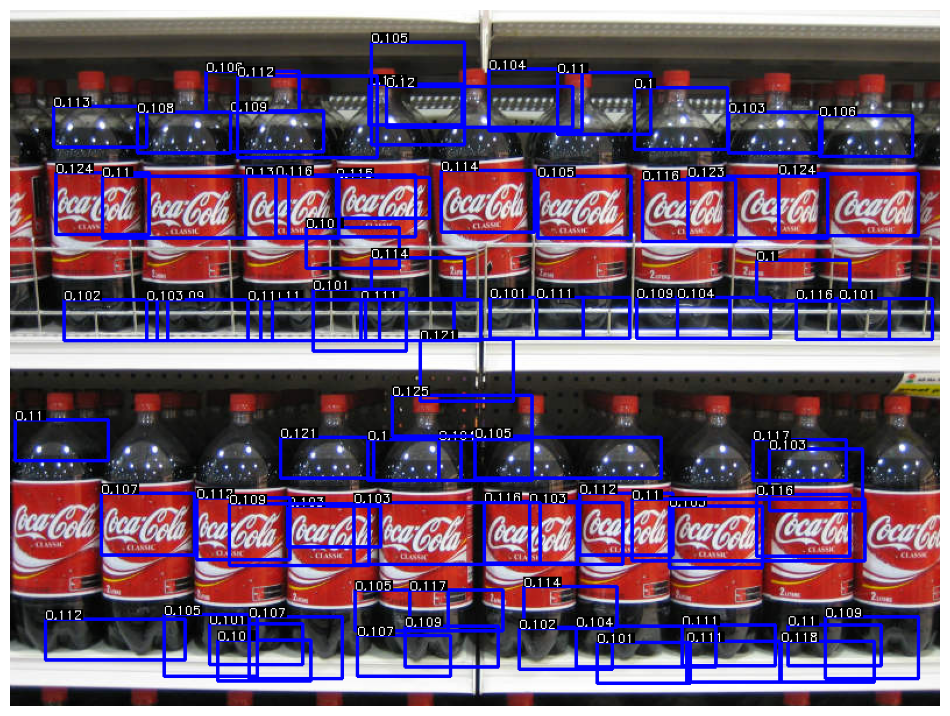

In [372]:
# a ver con gaussian blur previo tambien para template
dets, scores = multi_instance_template_matching(
    cv.GaussianBlur(img_gs, (5,5), sigmaX=3, sigmaY=3),
    cv.GaussianBlur(template,(5,5), sigmaX=3, sigmaY=3),
    threshold=0.1,
    scale_range = (0.2, 3),
    scale_step= 0.1,
    debug=True
)

print("Detecciones:",len(dets))

plot_boxes_xyxy(dets, scores, img_rgb, fontWidth=1, fontScale=0.35, color='blue')

Pareciera servir en _algunos_ casos.